# Задание 1

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

%matplotlib inline 

from tqdm.auto import tqdm

from scipy.stats import norm
from scipy.stats import chi2_contingency 

In [18]:
reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [19]:
#данные о времени регистрации
reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [20]:
# данные о времени захода пользователей в игру
auth

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [21]:
reg.dtypes


reg_ts    int64
uid       int64
dtype: object

In [22]:
auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [23]:
print(reg.isna().sum(), end ='\n')
print(auth.isna().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64


Пропущенных значений нет, теперь проверим на дубликаты

In [24]:
reg[reg.duplicated()]

,reg_ts,uid


In [25]:
auth[auth.duplicated()]

,auth_ts,uid


Дубликатов не было найдено. Проверим было ли две регистрации у одного пользователя. Для этого посчитаем встречается ли у одного айди больше 1 регистрации:

In [26]:
reg.groupby('uid', as_index = False).reg_ts.nunique().sort_values('reg_ts', ascending=False)

,uid,reg_ts
0,1,1
666657,740365,1
666659,740367,1
666660,740369,1
666661,740370,1
...,...,...
333337,370252,1
333338,370253,1
333339,370254,1
333340,370255,1


Таким образом видим, что не было не одной повторной регистрации. Переведем таблицы в нужный формат и объединим в одну таблицу.

In [ ]:
reg['reg_ts'] = pd.to_datetime(pd.to_datetime(reg.reg_ts, unit='s').dt.date)
auth['auth_ts'] = pd.to_datetime(pd.to_datetime(auth.auth_ts, unit='s').dt.date)

In [ ]:
#проверяем, что все перевелось правильно
reg

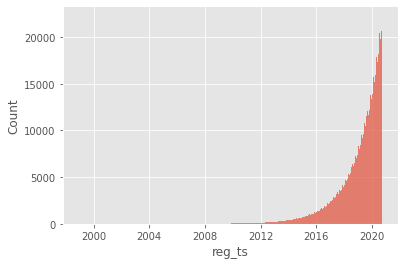

In [104]:
#Регистрация начиналась от 98 года вплоть до 2020. Посмотрим, как распределялась регистрация в течении этих лет
sns.histplot(x = 'reg_ts', data = reg)
#Видим, что активно игра начала развиваться только после 2016 года

In [17]:
df_retention = auth.merge(reg, on='uid')
print(df_retention)

           auth_ts      uid     reg_ts
0       1998-11-18        1 1998-11-18
1       1999-07-22        2 1999-07-22
2       1999-07-25        2 1999-07-22
3       1999-07-31        2 1999-07-22
4       1999-08-05        2 1999-07-22
...            ...      ...        ...
9601008 2020-09-23  1110618 2020-09-23
9601009 2020-09-23  1110619 2020-09-23
9601010 2020-09-23  1110620 2020-09-23
9601011 2020-09-23  1110621 2020-09-23
9601012 2020-09-23  1110622 2020-09-23

[9601013 rows x 3 columns]


Приступим к написанию функции для подсчета Retention.

In [18]:
def retention(df_retention, start_date, end_date, days):
    # df_retention - наш датафрейм
    #start_date - начало периода для расчета
    #end_date -конец периоды для расчета
    #days - продолжительность расчета retention
    
    # переводим данные в нужный вид и считаем колонку, которая показывает время, прошедшее со дня регистрации
    df_retention['days_diff'] = (df_retention ['auth_ts'] - df_retention ['reg_ts']).dt.days
    start_date = pd.to_datetime(start_date)
    end_date =  pd.to_datetime(end_date)
    days = int(days)
 
    #отфильтруем таблицу по заданному периоду
    df_retention = df_retention[(df_retention['reg_ts'] >= start_date)&(df_retention['reg_ts'] <= end_date)]
    df_retention = df_retention[(df_retention['auth_ts'] >= start_date)& (df_retention['auth_ts'] <= end_date)]
    #отфильтруем таблицу по данным по нужному количество дней
    df_retention = df_retention[df_retention['days_diff'] <= days]

    # разделим на когорты: посчитаем количество пользователей, сделаем сводную таблицу
    df_retention_1 = df_retention.groupby(['reg_ts', 'days_diff'])['uid'].nunique().reset_index()
    pivot_retention = df_retention_1.pivot(index='reg_ts', columns='days_diff', values='uid')
    retention = pivot_retention.divide(pivot_retention[0], axis=0)
    
     # Визуализурем результаты с помощью тепловой карты
    plt.figure(figsize=(25, 19))
    plt.title('Retention', fontsize=25)

    sns.heatmap(retention, annot=True, cmap='Blues', vmin=0.01, vmax=0.1,
               linewidths=.2, linecolor='white', fmt='.1%')
    plt.xlabel('Day', fontsize=15)
    plt.ylabel('Cohort', fontsize=15)
    plt.show()

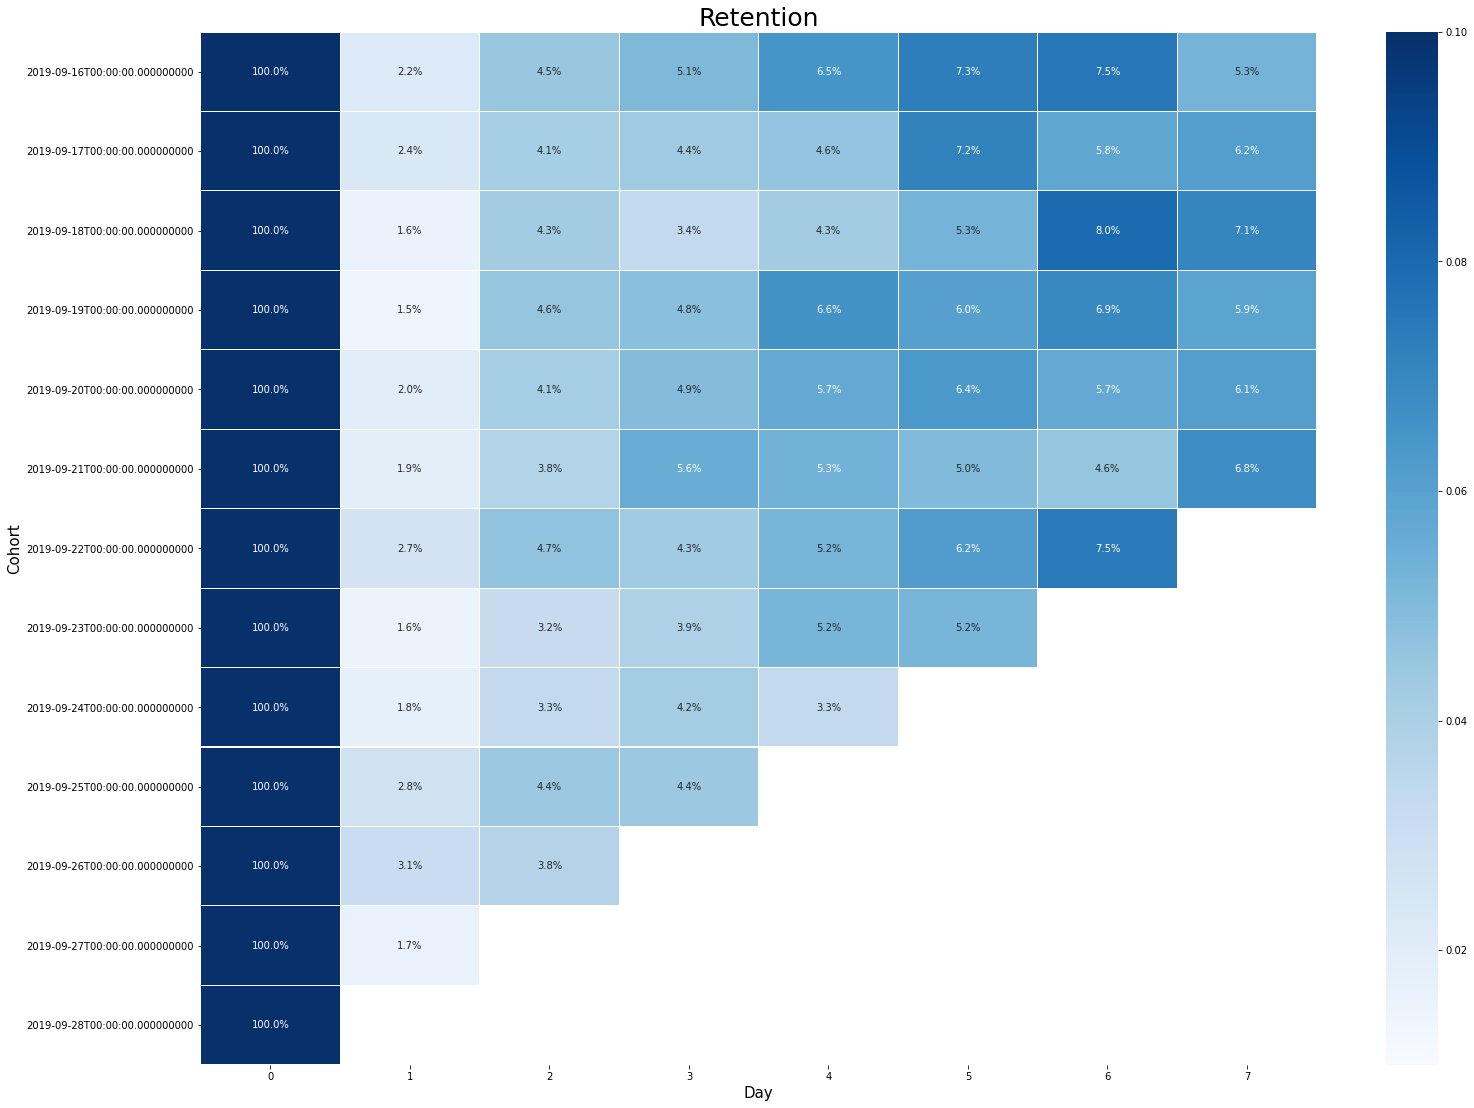

In [20]:
retention (df_retention, '2019-09-16', '2019-09-28', 7)

In [106]:
# на рисунке у меня даты некрасивые, не получается исправить

# Задание 2

##### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.



#### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
ab_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep =';')

In [4]:
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
#проверим на типы данных
ab_df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [6]:
#проверим на пропущенные значения
print(ab_df.isna().sum())
#пропущенных значений нет

user_id      0
revenue      0
testgroup    0
dtype: int64


In [7]:
#проверим на дубликаты
ab_df[ab_df.duplicated()]
#дубликатов не найдено

,user_id,revenue,testgroup


In [13]:
#посмотрим численность тестовой и контрольной группы
all_users = ab_df.groupby('testgroup').agg({'user_id' : 'count'})
all_users

,user_id
testgroup,
a,202103
b,202667


In [9]:
#посмотрим на численность платящих пользователей
paying_users = ab_df.query('revenue>0').groupby('testgroup').agg({'user_id' : 'count'})
paying_users
#объединим в сводную таблицу для расчета конверсии

,user_id
testgroup,
a,1928
b,1805


In [14]:
#объединим в сводную таблицу для расчета конверсии
df_cr = all_users.merge(paying_users, on = 'testgroup')
df_cr

,user_id_x,user_id_y
testgroup,,
a,202103,1928
b,202667,1805


In [12]:
df_cr['user_id_y'] /df_cr['user_id_x']

testgroup
a    0.009540
b    0.008906
dtype: float64

Заметим, что в тестовой группе конверсия в платящего пользователя уменьшилась. Проверим так ли это с помощью Хи квадрат \
Теперь посмотрим на средние значения и другие показатели групп а и b, а также в разрезе платящих пользователей

In [17]:
convertion = chi2_contingency(df_cr)[1]
convertion

0.03824373651044168

p-value>0, поэтому принимаем гипотезу о том, что различия статистически значимы, то есть конверсия при введении изменений снижается.

In [78]:
ab_df.query("testgroup == 'a'").revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [79]:
ab_df.query("testgroup == 'b'").revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

В контрольной группе(a) наблюдается очень высокое отклонение

In [80]:
ab_df.query("revenue > 0 & testgroup == 'a'").revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [81]:
ab_df.query("revenue > 0 & testgroup == 'b'").revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Также наблюдаем, что в группе платящих пользователей медианное значене выручки составляет 311, в тестовой группе 3022. \
Наблюдается ненормальное распределение в контрольной платящей группе (75 перцентиль равен 361, а максимум 37433), поэтому рассмотрим распределение на графиках.


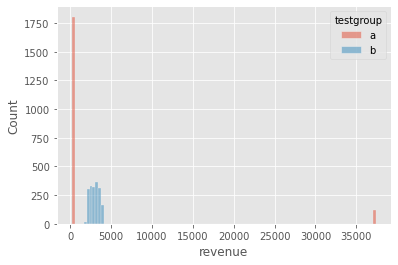

In [82]:
sns.histplot(x = 'revenue', data = ab_df.query('revenue > 0'), hue = 'testgroup')

Ярко прослеживаются выбросы в контрольной группе, распредление  ненормальное. \
Однако, согласно графику,  количество выбросов составляет примерно 150 человек, возможно, данную группу в буудщем логично выделить в отдельный сегмент.
На графике сложно проследить распределение тестовой группы, поэтому рассмотрим его на дополнительном графике.

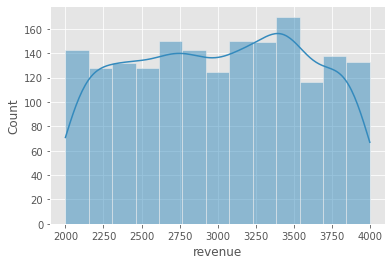

In [83]:
sns.histplot(x = 'revenue', data = ab_df.query("revenue > 0 & testgroup == 'b' "), kde=True)

Можно сказать, что распредление и в тестовой группе ненормальное, однако все же более равномерное, нежели в контрольной группе. 
Метрики, которые будут исследоваться для дальнейшего анализа: ARPU и ARPPU

##### Будет выбран метод бутстрапа, так как он более универсальный. 
Т-Тест не подходит, так как распределение в обоих выборках ненормальное. 
Можно использовать тест Манна-Уитни, но он плохо интерпретируется для бизнеса. 

In [84]:
def get_bootstrap(
    data_column_1,
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

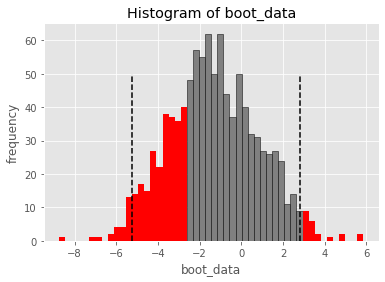

0.532

In [85]:
ab_ARPU = get_bootstrap(
    ab_df.query("testgroup == 'a'").revenue, 
    ab_df.query("testgroup == 'b'").revenue)
round(ab_ARPU['p_value'], 4)

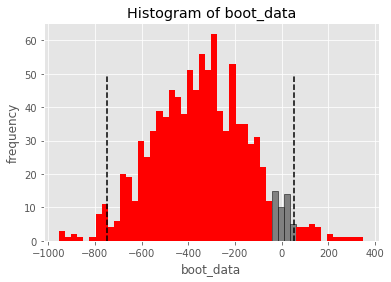

0.0912

In [87]:
ab_ARPPU = get_bootstrap(
    ab_df.query("testgroup == 'a' & revenue > 0 ").revenue, 
    ab_df.query("testgroup == 'b' & revenue > 0 ").revenue)
round(ab_ARPPU['p_value'], 4)

Таким образом, ни показатель ARPU, ни ARPPU не подвердили гипотезу о том, что в тестовой группе и контрольной есть статические различия (p-value составило > 0.05). 

### Выводы
Таким образом, была проведена оценка на нормальное распределение (распределения ненормальные, есть выбросы), был применен метод бутстрапа для оценки ARPU, ARPPU (группы а и б статически не различимы) \

Исследование показывает, что данные акции не рекомендуется вводить для всей группы пользователей, посколько снижается конверсия. Рекомендуется, перепроверить корректность проведения и сбора выборок для тестирования, так как они слишком не однородны.

# Задание 3

##### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?Предположим, в другом событии мы усложнили механику событий так,что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

###### 1) Для оценки результативности важно отслеживать следующие метрики \
Retention Rate (покажет заинтресованность пользоватлей в ходе провtдения события по дням) \
DAU (покажет сколько активных пользователей сейчас и можно будет сравнить Dau до события) \
CR_1 (из обычных пользователей в примающих участие в тем-ом событии) \
stickness (покажет, увеличилась ли частота использования сервиса -> вовлеченность) \
CR_2 (соотношение пользователей успешно прошедших определенное количество уровней или получивших награду / всех, принимавших участие)
Для оценки экономической эффективности понадобится показатель CPA, чтобы понять окупились ли затраты на привлечение пользователей к тематическому событию пользователей. \
###### 2) Метрики будут прежними, однако при усложнении задачи упор стоит сделать на retention n-го дня и конвесию из принимающего участие в успешного участника (CR_2).
